# South Korea's COVID-19 Data Analysis and Insights

## Introduction and Business Understanding

As I write this, the world is in the midst of a pandemic (the 10th deadliest pandemic in modern history). COVID-19 (Coronavirus Disease 2019) is an infectious respiratory disease caused by the SARS-CoV-2 virus, whose outbreak happened in the city of Wuhan — China, in the end of 2019, and rapidly spread across the world, reaching at least 215 countries, areas or territories.

In the age of big data, several governments and tech companies are using all data sources they can to understand the pandemic and design strategies to fight it. South Korea is one of these, with over 10,000 cases and around 250 deaths. KCDC (Korea Centers for Disease Control & Prevention) announces COVID-19 information quickly and transparently. Such information was aggregated and organized into a publicly available dataset.

I decided to analyze such data, using Data Science techniques to provide insights that can benefit both governments/authorities and the population in general. The analyses presented here are structured in the form of questions to facilitate their understanding and favor objectivity, aiming to reach clear results.

#### [Dataset Description](https://www.kaggle.com/kimjihoo/ds4c-what-is-this-dataset-detailed-description)

***

## Questions

### I - How did the disease spread within the provinces over time?

This analysis is important for the government authorities, as they can use it to evaluate the effectiveness of the strategies used to fight COVID-19 in the different regions of the country.

### II - What characteristics are good predictors of the patient status?

This question is posed thinking of a scenario where, for instance, a hospital triage facility wants to identify ahead of time the risk of death of a patient whose COVID-19 infection was just confirmed, in order to perform prioritization to special care.

### III - What are the riskiest locations for COVID-19 infection in Seoul (where infected people have visited the most)?

In a limited resources scenario (as usual), authorities might need to choose which regions of a province/city to prioritize for enforcing deeper prevention actions, such as mass testing and building and street sanitizing.
This last question was thought as a materialization of the above demand in the case of Seoul.

***

## Analyses

### Importing Libraries

In [1]:
# Basic Data Analysis libraries (all questions)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Scikit-Learn Model libraries (question II)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Geoplot libraries (question III)
import geopandas
import shapely.geometry as geom
import geoplot
import mapclassify
#Install the extra libs with the following command: conda install -c conda-forge geoplot geopandas shapely

### I - How did the disease spread within the provinces over time?

In order to perform such analysis, I use the data comprising the number of accumulated infections over time for each province, and to have a fair comparison between the provinces, I define the number of days since the day of the 1st infection (in each province) as the time unit and compute the number of cases per million people in the province.

#### Reading Data - Infections over Time per Province

In [2]:
infections_prov_time = pd.read_csv('../../data/TimeProvince.csv')

##### Quick Data Exploration

In [3]:
infections_prov_time.head()

,date,time,province,confirmed,released,deceased
0,2020-01-20,16,Seoul,0,0,0
1,2020-01-20,16,Busan,0,0,0
2,2020-01-20,16,Daegu,0,0,0
3,2020-01-20,16,Incheon,1,0,0
4,2020-01-20,16,Gwangju,0,0,0


In [4]:
infections_prov_time.describe()

,time,confirmed,released,deceased
count,1564.000000,1564.000000,1564.000000,1564.000000
mean,7.304348,290.842711,126.927749,4.335038
std,7.972246,1112.384174,642.360989,19.190269
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,14.000000,2.000000,0.000000
75%,16.000000,72.250000,21.000000,0.000000
max,16.000000,6833.000000,5769.000000,163.000000


In [5]:
infections_prov_time[infections_prov_time['province'] == 'Seoul'].sort_values(['province','date']).head()

,date,time,province,confirmed,released,deceased
0,2020-01-20,16,Seoul,0,0,0
17,2020-01-21,16,Seoul,0,0,0
34,2020-01-22,16,Seoul,0,0,0
51,2020-01-23,16,Seoul,0,0,0
68,2020-01-24,16,Seoul,0,0,0


#### Munging data to compute the number of infections per day since 1st infection day

In [6]:
infections_prov_time_clean = infections_prov_time.rename(index=str, columns={'confirmed':'accum_confirmed',
                                                                             'released':'accum_released',
                                                                             'deceased':'accum_deceased'})

infections_prov_time_clean

,date,time,province,accum_confirmed,accum_released,accum_deceased
0,2020-01-20,16,Seoul,0,0,0
1,2020-01-20,16,Busan,0,0,0
2,2020-01-20,16,Daegu,0,0,0
3,2020-01-20,16,Incheon,1,0,0
4,2020-01-20,16,Gwangju,0,0,0
...,...,...,...,...,...,...
1559,2020-04-20,0,Jeollabuk-do,17,9,0
1560,2020-04-20,0,Jeollanam-do,15,8,0
1561,2020-04-20,0,Gyeongsangbuk-do,1361,1064,51
1562,2020-04-20,0,Gyeongsangnam-do,116,87,0


In [7]:
#Finding date of 1st infection per province
day_one_per_province = infections_prov_time_clean[infections_prov_time_clean['accum_confirmed'] > 0] \
                                                  .sort_values(['province','date']) \
                                                  .groupby(['province']) \
                                                  .head(1) \
                                                  .reset_index() \
                                                  .filter(['province','date']) \
                                                  .assign(days_since_day1 = 1)

day_one_per_province

,province,date,days_since_day1
0,Busan,2020-02-20,1
1,Chungcheongbuk-do,2020-02-21,1
2,Chungcheongnam-do,2020-02-21,1
3,Daegu,2020-02-18,1
4,Daejeon,2020-02-22,1
5,Gangwon-do,2020-02-22,1
6,Gwangju,2020-02-04,1
7,Gyeonggi-do,2020-01-24,1
8,Gyeongsangbuk-do,2020-02-19,1
9,Gyeongsangnam-do,2020-02-19,1


In [8]:
# Adding the 1st infection date per province as a column to the infections data frame
infections_since_day1 = pd.merge(infections_prov_time_clean,day_one_per_province, how='left')

In [9]:
# Computing the number of days since 1st infection date for each date per province and 
# Keeping only data from 1st infection date on per province
infections_since_day1['after_day1'] = infections_since_day1.groupby(['province']).days_since_day1.transform(lambda x : x.ffill())
infections_since_day1 = infections_since_day1[infections_since_day1['after_day1'] == 1]
infections_since_day1['days_since_day1'] = infections_since_day1.groupby(['province']).after_day1.transform(lambda x : x.cumsum())
infections_since_day1 = infections_since_day1.drop(columns=['after_day1'], axis=1)
infections_since_day1

,date,time,province,accum_confirmed,accum_released,accum_deceased,days_since_day1
3,2020-01-20,16,Incheon,1,0,0,1.0
20,2020-01-21,16,Incheon,1,0,0,2.0
37,2020-01-22,16,Incheon,1,0,0,3.0
54,2020-01-23,16,Incheon,1,0,0,4.0
71,2020-01-24,16,Incheon,1,0,0,5.0
...,...,...,...,...,...,...,...
1559,2020-04-20,0,Jeollabuk-do,17,9,0,81.0
1560,2020-04-20,0,Jeollanam-do,15,8,0,59.0
1561,2020-04-20,0,Gyeongsangbuk-do,1361,1064,51,62.0
1562,2020-04-20,0,Gyeongsangnam-do,116,87,0,62.0


In [10]:
infections_since_day1.sort_values(['days_since_day1','province'])

,date,time,province,accum_confirmed,accum_released,accum_deceased,days_since_day1
528,2020-02-20,16,Busan,8,0,0,1.0
554,2020-02-21,16,Chungcheongbuk-do,1,0,0,1.0
555,2020-02-21,16,Chungcheongnam-do,1,0,0,1.0
495,2020-02-18,16,Daegu,1,0,0,1.0
566,2020-02-22,16,Daejeon,2,0,0,1.0
...,...,...,...,...,...,...,...
1482,2020-04-16,0,Incheon,88,51,0,88.0
1499,2020-04-17,0,Incheon,89,51,0,89.0
1516,2020-04-18,0,Incheon,90,55,0,90.0
1533,2020-04-19,0,Incheon,91,55,0,91.0


#### Adding population density data to compute proportional rates

In [11]:
province_data = {
    'province': ['Gyeonggi-do', 'Gangwon-do', 'Chungcheongbuk-do', 'Chungcheongnam-do', 'Jeollabuk-do', 'Jeollanam-do', 
    'Gyeongsangbuk-do', 'Gyeongsangnam-do', 'Busan', 'Daegu', 'Daejeon', 'Gwangju', 'Incheon', 'Ulsan', 'Seoul', 'Jeju-do', 'Sejong'],
    'population': [12479061, 1518040, 1589377, 2107802, 1834114, 1799044, 2680294, 3334524, 3448737, 2466052, 1538394, 1502881, 2890451, 1166615, 9904312, 605619, 204088],
    'area': [10183.5, 16827.1, 7407.3, 8226.1, 8069.1, 12318.8, 19031.4, 10539.6, 769.6, 883.6, 539.3, 501.2, 1062.6, 1060.8, 605.2, 1849.1, 464.9]
}

provinces = pd.DataFrame(data = province_data, columns = ['province', 'population', 'area'])
provinces['pop_density'] = provinces['population'] / provinces['area']

In [12]:
provinces

,province,population,area,pop_density
0,Gyeonggi-do,12479061,10183.5,1225.419649
1,Gangwon-do,1518040,16827.1,90.214000
2,Chungcheongbuk-do,1589377,7407.3,214.569006
3,Chungcheongnam-do,2107802,8226.1,256.233452
4,Jeollabuk-do,1834114,8069.1,227.300938
5,Jeollanam-do,1799044,12318.8,146.040523
6,Gyeongsangbuk-do,2680294,19031.4,140.835356
7,Gyeongsangnam-do,3334524,10539.6,316.380508
8,Busan,3448737,769.6,4481.207121
9,Daegu,2466052,883.6,2790.914441


In [13]:
# Merging infections data with province data
infections_since_day1_full = pd.merge(infections_since_day1, provinces, how='left')

# Computing population infection metrics
infections_since_day1_full['accum_confirmed_perc_total_pop'] = 100 * (infections_since_day1_full['accum_confirmed'] / infections_since_day1_full['population'])
infections_since_day1_full['accum_confirmed_per_million_people'] = (infections_since_day1_full['accum_confirmed'] / (infections_since_day1_full['population']/10**6))
infections_since_day1_full

,date,time,province,accum_confirmed,accum_released,accum_deceased,days_since_day1,population,area,pop_density,accum_confirmed_perc_total_pop,accum_confirmed_per_million_people
0,2020-01-20,16,Incheon,1,0,0,1.0,2890451,1062.6,2720.168455,0.000035,0.345967
1,2020-01-21,16,Incheon,1,0,0,2.0,2890451,1062.6,2720.168455,0.000035,0.345967
2,2020-01-22,16,Incheon,1,0,0,3.0,2890451,1062.6,2720.168455,0.000035,0.345967
3,2020-01-23,16,Incheon,1,0,0,4.0,2890451,1062.6,2720.168455,0.000035,0.345967
4,2020-01-24,16,Incheon,1,0,0,5.0,2890451,1062.6,2720.168455,0.000035,0.345967
...,...,...,...,...,...,...,...,...,...,...,...,...
1141,2020-04-20,0,Jeollabuk-do,17,9,0,81.0,1834114,8069.1,227.300938,0.000927,9.268780
1142,2020-04-20,0,Jeollanam-do,15,8,0,59.0,1799044,12318.8,146.040523,0.000834,8.337762
1143,2020-04-20,0,Gyeongsangbuk-do,1361,1064,51,62.0,2680294,19031.4,140.835356,0.050778,507.780117
1144,2020-04-20,0,Gyeongsangnam-do,116,87,0,62.0,3334524,10539.6,316.380508,0.003479,34.787574


#### Finding the provinces with higher infection rate (actual numbers and proportional numbers)

In [14]:
total_per_province = infections_since_day1_full.sort_values(['province','date']).groupby('province').tail(1).reset_index()
total_per_province = total_per_province[['date','province','days_since_day1','population','pop_density','accum_confirmed','accum_confirmed_perc_total_pop','accum_confirmed_per_million_people']]
total_per_province

,date,province,days_since_day1,population,pop_density,accum_confirmed,accum_confirmed_perc_total_pop,accum_confirmed_per_million_people
0,2020-04-20,Busan,61.0,3448737,4481.207121,132,0.003827,38.274882
1,2020-04-20,Chungcheongbuk-do,60.0,1589377,214.569006,45,0.002831,28.312980
2,2020-04-20,Chungcheongnam-do,60.0,2107802,256.233452,141,0.006689,66.894329
3,2020-04-20,Daegu,63.0,2466052,2790.914441,6833,0.277083,2770.825595
4,2020-04-20,Daejeon,59.0,1538394,2852.575561,39,0.002535,25.351113
5,2020-04-20,Gangwon-do,59.0,1518040,90.214000,53,0.003491,34.913441
6,2020-04-20,Gwangju,77.0,1502881,2998.565443,30,0.001996,19.961660
7,2020-04-20,Gyeonggi-do,88.0,12479061,1225.419649,656,0.005257,52.568058
8,2020-04-20,Gyeongsangbuk-do,62.0,2680294,140.835356,1361,0.050778,507.780117
9,2020-04-20,Gyeongsangnam-do,62.0,3334524,316.380508,116,0.003479,34.787574


In [15]:
province_inf_rate_real_nos = total_per_province.sort_values('accum_confirmed', ascending=False)
province_inf_rate_real_nos

,date,province,days_since_day1,population,pop_density,accum_confirmed,accum_confirmed_perc_total_pop,accum_confirmed_per_million_people
3,2020-04-20,Daegu,63.0,2466052,2790.914441,6833,0.277083,2770.825595
8,2020-04-20,Gyeongsangbuk-do,62.0,2680294,140.835356,1361,0.050778,507.780117
7,2020-04-20,Gyeonggi-do,88.0,12479061,1225.419649,656,0.005257,52.568058
15,2020-04-20,Seoul,85.0,9904312,16365.353602,624,0.006300,63.002862
2,2020-04-20,Chungcheongnam-do,60.0,2107802,256.233452,141,0.006689,66.894329
0,2020-04-20,Busan,61.0,3448737,4481.207121,132,0.003827,38.274882
9,2020-04-20,Gyeongsangnam-do,62.0,3334524,316.380508,116,0.003479,34.787574
10,2020-04-20,Incheon,92.0,2890451,2720.168455,92,0.003183,31.828943
5,2020-04-20,Gangwon-do,59.0,1518040,90.214000,53,0.003491,34.913441
14,2020-04-20,Sejong,59.0,204088,438.993332,46,0.022539,225.392968


In [16]:
def plot_infection_curve_per_province(infections_data, provinces, infections_var, title, ylabel, 
                                      log_scale=False, figsize=(10,6), filepath=''):
    '''
    INPUT
    infections_data - pandas dataframe, infections data
    provinces - list of strings, the subset of provinces to be used
    infections_var - string, varible in the dataset to be used in plot y axis
    title - string, plot title
    ylabel - string, plot y-axis label
    log_scale - boolean, default False, whether or not to use log scale on y axis
    figsize - int tuple, default (10, 6), plot figure size
    filepath - string, default '' (not save), filepath to save plot image to
    

    OUTPUT
    A line plot representing the infection curve of the given provinces over time since the 1st day of infection
    
    This function plots the COVID-19 infection curve of a set of provinces using a line plot
    '''
    
    # Defines a color palette for each province in the top provinces in the number of cases
    provinces_palette = {'Daegu':'#9b59b6', 'Gyeongsangbuk-do':'#3498db', 'Gyeonggi-do':'#95a5a6','Seoul':'#e74c3c', 
                         'Chungcheongnam-do':'#34495e', 'Sejong':'#2ecc71'}
    
    # Plots figure with characteristics based on the input parameters
    f = plt.figure(figsize=figsize)
    sns.set_style('whitegrid')
    p = sns.lineplot(x="days_since_day1",
                     y=infections_var,
                     hue="province",
                     data=infections_data[infections_data.province.isin(provinces)],
                     palette=provinces_palette)
    p.axes.set_title(title, fontsize = 16, weight='bold')
    p.set_xlabel('Days since day 1', fontsize = 10)
    p.set_ylabel(ylabel, fontsize = 10)
    
    # Uses log scale on the y axis (if requested)
    if log_scale: p.set_yscale("log")
        
    # Saves figure to the specified filepath (if passed)
    if (filepath != ''): f.savefig(filepath, bbox_inches='tight', dpi=600);   

In [17]:
# Top 5 provinces in terms of accumulated infections per million people
total_per_province.sort_values('accum_confirmed_per_million_people', ascending=False).head(5)

,date,province,days_since_day1,population,pop_density,accum_confirmed,accum_confirmed_perc_total_pop,accum_confirmed_per_million_people
3,2020-04-20,Daegu,63.0,2466052,2790.914441,6833,0.277083,2770.825595
8,2020-04-20,Gyeongsangbuk-do,62.0,2680294,140.835356,1361,0.050778,507.780117
14,2020-04-20,Sejong,59.0,204088,438.993332,46,0.022539,225.392968
2,2020-04-20,Chungcheongnam-do,60.0,2107802,256.233452,141,0.006689,66.894329
15,2020-04-20,Seoul,85.0,9904312,16365.353602,624,0.006300,63.002862


### Answer to Question I

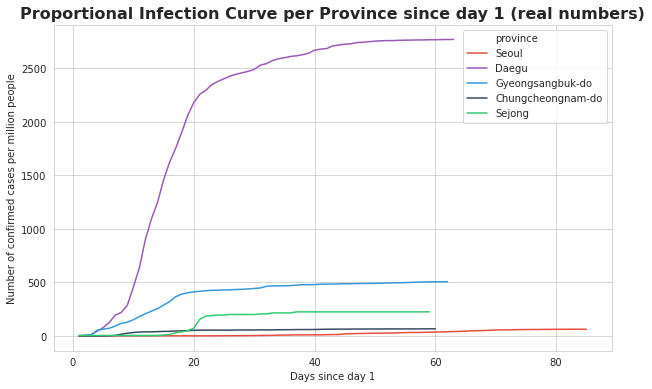

In [18]:
# Computes top 5 provinces in terms of accumulated number of cases per million people
# Plots infection curve for all provinces in the top-5

top_infected_provinces_perm_nos = total_per_province.sort_values('accum_confirmed_per_million_people', ascending=False).head(5).province
plot_infection_curve_per_province(infections_data=infections_since_day1_full, 
                                  provinces=top_infected_provinces_perm_nos, 
                                  infections_var='accum_confirmed_per_million_people', 
                                  title='Proportional Infection Curve per Province since day 1 (real numbers)',
                                  ylabel='Number of confirmed cases per million people',
                                  filepath='../../assets/q1-province-infections-over-time-real.png')

Here, we see the infection curve for the top-5 provinces with more cases (in total). As we can see, the Daegu province has the worst case with over 2,500 infections per million people in 2 months. It is the epicenter of the disease in South Korea, after the so called patient 31 had contact with over 1,000 people in a christian mega-church, which ended up in thousands of infections.

The second one is Gyeongsangbuk-do (Daegu’s surrounding province — check it on the map) with around 500 cases per million people. The other provinces in the top-5 had all less than 250 cases/1M people. In order to have a better look in the curve behavior for the provinces with less cases, we can use a log-scale.

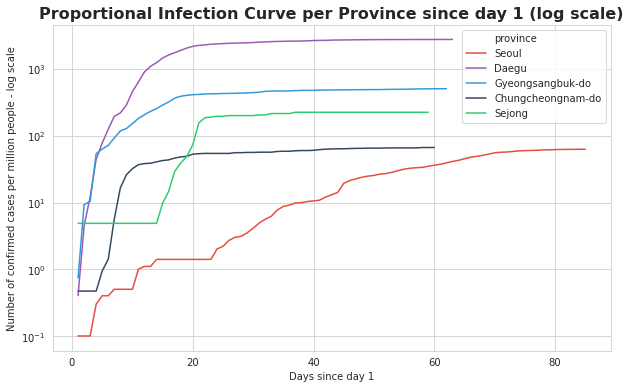

In [19]:
# Uses top 5 provinces in terms of accumulated number of cases per million people
# Plots infection curve for all provinces in the top-5 applying a log-scale to y-axis

plot_infection_curve_per_province(infections_data=infections_since_day1_full, 
                                  provinces=top_infected_provinces_perm_nos, 
                                  infections_var='accum_confirmed_per_million_people', 
                                  title='Proportional Infection Curve per Province since day 1 (log scale)',
                                  ylabel='Number of confirmed cases per million people - log scale',
                                  filepath='../../assets/q1-province-infections-over-time-log.png',
                                  log_scale=True)

Now we are able to observe the pattern followed by the cases in each province in more detail. We see that, except for Seoul, all provinces had their fastest spread of the disease during the first 20 days after the first case, being able to stabilize the curve afterwards.

The Sejong province had a very high increase in the number of cases between the 10th and 20th days of the infections, with its curve going roughly straight in the logarithmic scale, which indicates an exponential growth. In the case of Seoul, it seemed to have controlled the dissemination of the virus around the 20th day of the first infection, but later on the curve started growing again, only coming back to stability around day 80.

***

### II - What characteristics are good predictors of the patient status?

To perform this analysis, the patient info data was used. I chose the following input variables (possible influencing factors):

- Sex (male/female)
- Age Range (0: 0–9 years old; 1: 10–19 years old; and so on)
- Infection Case: The type of infection (overseas inflow, contact with other patients, group infections, and etc. — other types)
- Province: The province of the patient

To performe the prediction task, I decided to use a Logistic Regression model with two classes:

- Released
- Deceased

#### Reading Data - Patient Info

In [20]:
patient_info = pd.read_csv('../../data/PatientInfo.csv')

#### Taking a look at the data

In [21]:
patient_info.head(30)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released
5,1000000006,10.0,female,1966.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,3.0,1.000000e+09,43.0,NaN,2020-01-31,2020-02-19,NaN,released
6,1000000007,11.0,male,1995.0,20s,Korea,Seoul,Jongno-gu,NaN,contact with patient,3.0,1.000000e+09,0.0,NaN,2020-01-31,2020-02-10,NaN,released
7,1000000008,13.0,male,1992.0,20s,Korea,Seoul,etc,NaN,overseas inflow,1.0,NaN,0.0,NaN,2020-02-02,2020-02-24,NaN,released
8,1000000009,19.0,male,1983.0,30s,Korea,Seoul,Songpa-gu,NaN,overseas inflow,2.0,NaN,68.0,NaN,2020-02-05,2020-02-21,NaN,released
9,1000000010,21.0,female,1960.0,60s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,3.0,1.000000e+09,6.0,NaN,2020-02-05,2020-02-29,NaN,released


In [22]:
patient_info.shape

(3326, 18)

In [23]:
patient_info.describe()

,patient_id,global_num,birth_year,infection_order,infected_by,contact_number
count,3.326000e+03,2237.000000,2889.000000,31.000000,8.060000e+02,614.000000
mean,3.514908e+09,6669.169423,1974.956732,2.387097,2.671714e+09,18.710098
std,2.209142e+09,3321.396732,20.275471,1.453213,1.740450e+09,75.352899
min,1.000000e+09,1.000000,1916.000000,1.000000,1.000000e+09,0.000000
25%,1.300000e+09,4172.000000,1961.000000,1.000000,1.200000e+09,2.000000
50%,2.000001e+09,7855.000000,1975.000000,2.000000,2.000000e+09,4.000000
75%,6.001001e+09,9433.000000,1993.000000,3.000000,4.100000e+09,14.000000
max,7.000000e+09,10660.000000,2020.000000,6.000000,7.000000e+09,1160.000000


In [24]:
patient_info.describe(include=['object'])

,sex,age,country,province,city,disease,infection_case,symptom_onset_date,confirmed_date,released_date,deceased_date,state
count,3260,3252,3326,3326,3247,18,2559,471,3323,1218,60,3326
unique,2,11,11,17,151,1,23,69,77,66,33,3
top,female,20s,Korea,Gyeongsangbuk-do,Gyeongsan-si,True,contact with patient,2020-02-27,2020-03-05,2020-03-20,2020-03-02,released
freq,1831,790,3300,1223,631,18,949,29,145,69,4,1637


#### Checking for missing data

In [25]:
patient_info.apply(lambda x: x.isnull().mean(), axis=0).sort_values(ascending=False)

disease               0.994588
infection_order       0.990679
deceased_date         0.981960
symptom_onset_date    0.858388
contact_number        0.815394
infected_by           0.757667
released_date         0.633794
global_num            0.327420
infection_case        0.230607
birth_year            0.131389
city                  0.023752
age                   0.022249
sex                   0.019844
confirmed_date        0.000902
state                 0.000000
country               0.000000
province              0.000000
patient_id            0.000000
dtype: float64

#### Model Design

##### Model V. 0.1 - y ~ X:
- y = state
- X = f ( province, sex, age, infection_case )

In [26]:
model_v01_data = patient_info[['province', 'sex', 'age', 'infection_case', 'state']]

In [27]:
print(model_v01_data.shape)
model_v01_data.head()

(3326, 5)


,province,sex,age,infection_case,state
0,Seoul,male,50s,overseas inflow,released
1,Seoul,male,30s,overseas inflow,released
2,Seoul,male,50s,contact with patient,released
3,Seoul,male,20s,overseas inflow,released
4,Seoul,female,20s,contact with patient,released


##### Deciding what to do for each column (missing data, value encoding, data treatment)

###### infection_case

In [28]:
patients_infection_case = patient_info[~patient_info['infection_case'].isnull()]
print(patients_infection_case.shape)
patients_infection_case.sort_values(['confirmed_date'])

(2559, 18)


,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
846,1400000001,1.0,female,1985.0,30s,China,Incheon,etc,NaN,overseas inflow,NaN,NaN,NaN,2020-01-19,2020-01-20,2020-02-06,NaN,released
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1065,2000000001,3.0,male,1966.0,50s,Korea,Gyeonggi-do,Goyang-si,NaN,overseas inflow,1.0,NaN,16.0,NaN,2020-01-26,2020-02-12,NaN,released
1066,2000000002,4.0,male,1964.0,50s,Korea,Gyeonggi-do,Pyeongtaek-si,NaN,overseas inflow,1.0,NaN,95.0,NaN,2020-01-27,2020-02-09,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,2000000656,NaN,male,1964.0,50s,Korea,Gyeonggi-do,Namyangju-si,NaN,contact with patient,NaN,2.000001e+09,NaN,NaN,2020-04-19,NaN,NaN,isolated
937,1400000092,NaN,male,1992.0,20s,Korea,Incheon,Gyeyang-gu,NaN,overseas inflow,NaN,NaN,NaN,NaN,2020-04-19,NaN,NaN,isolated
2923,6011000051,NaN,female,1980.0,40s,Korea,Gyeongsangbuk-do,Andong-si,NaN,etc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,isolated
2924,6011000052,NaN,female,2011.0,0s,Korea,Gyeongsangbuk-do,Andong-si,NaN,etc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,isolated


In [29]:
patients_infection_case.state.value_counts()

isolated    1437
released    1094
deceased      28
Name: state, dtype: int64

In [30]:
patients_infection_case.infection_case.value_counts()

contact with patient                     949
etc                                      567
overseas inflow                          567
Guro-gu Call Center                      112
Shincheonji Church                       107
Onchun Church                             33
Bonghwa Pureun Nursing Home               31
gym facility in Cheonan                   30
Ministry of Oceans and Fisheries          28
Cheongdo Daenam Hospital                  21
Dongan Church                             17
Eunpyeong St. Mary's Hospital             16
Gyeongsan Seorin Nursing Home             15
Seongdong-gu APT                          13
Gyeongsan Jeil Silver Town                12
Milal Shelter                             11
Gyeongsan Cham Joeun Community Center     10
Geochang Church                            6
Changnyeong Coin Karaoke                   4
gym facility in Sejong                     4
Suyeong-gu Kindergarten                    3
Pilgrimage to Israel                       2
River of G

As we can see, this column has data which encompasses old and current dates, and comprises all possible patient states. There are many infection case levels (group infections) which are not going to be individually relevant to the prediction model. Thus, we will keep only three of the original levels: Contact with Patient, Overseas Inflow and etc, and label the rest as Group Infection. As it is a categorical variable, we will create a dummy variable to hold its NA values.

In [31]:
def resume_infection_case_col(inf_case_value):
    '''
    INPUT:
    inf_case_value - the infection case value string

    OUTPUT:
    simplified_infection_case_val - the simplified infection case value string (with less categories)
    
    This function translates the infection case values to one of the four final groups: 
    [contact with patient, overseas inflow, group_infection, etc].
    '''
    
    simplified_infection_case_val = ''
    if ((pd.isnull(inf_case_value)) or (inf_case_value in ['contact with patient','overseas inflow','etc'])):
        simplified_infection_case_val = inf_case_value
    else:
        simplified_infection_case_val = 'group_infection'
    
    return simplified_infection_case_val
    
model_v01_data.loc[:,'infection_case'] = model_v01_data['infection_case'].apply(resume_infection_case_col)

/local/tarciso/anaconda3/envs/udacity-ds-p1/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [32]:
model_v01_data.head(20)

,province,sex,age,infection_case,state
0,Seoul,male,50s,overseas inflow,released
1,Seoul,male,30s,overseas inflow,released
2,Seoul,male,50s,contact with patient,released
3,Seoul,male,20s,overseas inflow,released
4,Seoul,female,20s,contact with patient,released
5,Seoul,female,50s,contact with patient,released
6,Seoul,male,20s,contact with patient,released
7,Seoul,male,20s,overseas inflow,released
8,Seoul,male,30s,overseas inflow,released
9,Seoul,female,60s,contact with patient,released


In [33]:
model_v01_data = pd.get_dummies(data = model_v01_data, prefix = 'infection_case', prefix_sep = ':', columns = ['infection_case'], drop_first = False, dummy_na = True)

In [34]:
model_v01_data.head()

,province,sex,age,state,infection_case:contact with patient,infection_case:etc,infection_case:group_infection,infection_case:overseas inflow,infection_case:nan
0,Seoul,male,50s,released,0,0,0,1,0
1,Seoul,male,30s,released,0,0,0,1,0
2,Seoul,male,50s,released,1,0,0,0,0
3,Seoul,male,20s,released,0,0,0,1,0
4,Seoul,female,20s,released,1,0,0,0,0


###### age

In [35]:
patients_age = patient_info[~patient_info['age'].isnull()]
print(patients_age.shape)
patients_age.sort_values(['confirmed_date'])

(3252, 18)


,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
846,1400000001,1.0,female,1985.0,30s,China,Incheon,etc,NaN,overseas inflow,NaN,NaN,NaN,2020-01-19,2020-01-20,2020-02-06,NaN,released
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1065,2000000001,3.0,male,1966.0,50s,Korea,Gyeonggi-do,Goyang-si,NaN,overseas inflow,1.0,NaN,16.0,NaN,2020-01-26,2020-02-12,NaN,released
1066,2000000002,4.0,male,1964.0,50s,Korea,Gyeonggi-do,Pyeongtaek-si,NaN,overseas inflow,1.0,NaN,95.0,NaN,2020-01-27,2020-02-09,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719,2000000655,NaN,female,1998.0,20s,Korea,Gyeonggi-do,Yongin-si,NaN,overseas inflow,NaN,NaN,NaN,NaN,2020-04-19,NaN,NaN,isolated
937,1400000092,NaN,male,1992.0,20s,Korea,Incheon,Gyeyang-gu,NaN,overseas inflow,NaN,NaN,NaN,NaN,2020-04-19,NaN,NaN,isolated
2923,6011000051,NaN,female,1980.0,40s,Korea,Gyeongsangbuk-do,Andong-si,NaN,etc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,isolated
2924,6011000052,NaN,female,2011.0,0s,Korea,Gyeongsangbuk-do,Andong-si,NaN,etc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,isolated


In [36]:
patient_info[patient_info['age'].isnull() & (~patient_info['birth_year'].isnull())]

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state


In [37]:
patients_age.state.value_counts()

released    1627
isolated    1558
deceased      67
Name: state, dtype: int64

In [38]:
patients_age.age.value_counts()

20s     790
50s     589
40s     453
30s     425
60s     398
70s     197
80s     155
10s     146
0s       53
90s      45
100s      1
Name: age, dtype: int64

As we can see, this column has data which encompasses old and current dates, and comprises all possible patient states. As it is in essence a numeric variable, we will turn it into one, and will fill in its missing values with the mean.

In [39]:
model_v01_data.loc[:,'age'] = model_v01_data.age.str.replace('s','').astype('float')
model_v01_data.loc[:,'age'] = model_v01_data.age.fillna(model_v01_data.age.mean())

In [40]:
model_v01_data

,province,sex,age,state,infection_case:contact with patient,infection_case:etc,infection_case:group_infection,infection_case:overseas inflow,infection_case:nan
0,Seoul,male,50.0,released,0,0,0,1,0
1,Seoul,male,30.0,released,0,0,0,1,0
2,Seoul,male,50.0,released,1,0,0,0,0
3,Seoul,male,20.0,released,0,0,0,1,0
4,Seoul,female,20.0,released,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
3321,Jeju-do,female,20.0,isolated,0,0,0,1,0
3322,Jeju-do,female,20.0,isolated,0,0,0,1,0
3323,Jeju-do,male,30.0,isolated,1,0,0,0,0
3324,Jeju-do,female,20.0,isolated,0,0,0,1,0


In [41]:
model_v01_data.age.mean()

40.528905289052865

In [42]:
model_v01_data[model_v01_data['age'] == patient_info.age.str.replace('s','').astype(float).mean()]

,province,sex,age,state,infection_case:contact with patient,infection_case:etc,infection_case:group_infection,infection_case:overseas inflow,infection_case:nan
563,Seoul,NaN,40.528905,released,0,1,0,0,0
564,Seoul,NaN,40.528905,isolated,0,0,0,1,0
565,Seoul,NaN,40.528905,isolated,0,0,0,1,0
566,Seoul,NaN,40.528905,isolated,0,0,0,1,0
567,Seoul,NaN,40.528905,isolated,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
2926,Gyeongsangbuk-do,female,40.528905,released,0,1,0,0,0
2927,Gyeongsangbuk-do,NaN,40.528905,released,0,1,0,0,0
3228,Gyeongsangnam-do,NaN,40.528905,isolated,0,0,0,0,1
3229,Gyeongsangnam-do,NaN,40.528905,isolated,0,0,0,0,1


###### sex

In [43]:
patients_sex = patient_info[~patient_info['sex'].isnull()]
print(patients_sex.shape)
patients_sex.sort_values(['confirmed_date'])

(3260, 18)


,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
846,1400000001,1.0,female,1985.0,30s,China,Incheon,etc,NaN,overseas inflow,NaN,NaN,NaN,2020-01-19,2020-01-20,2020-02-06,NaN,released
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1065,2000000001,3.0,male,1966.0,50s,Korea,Gyeonggi-do,Goyang-si,NaN,overseas inflow,1.0,NaN,16.0,NaN,2020-01-26,2020-02-12,NaN,released
1066,2000000002,4.0,male,1964.0,50s,Korea,Gyeonggi-do,Pyeongtaek-si,NaN,overseas inflow,1.0,NaN,95.0,NaN,2020-01-27,2020-02-09,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,2000000656,NaN,male,1964.0,50s,Korea,Gyeonggi-do,Namyangju-si,NaN,contact with patient,NaN,2.000001e+09,NaN,NaN,2020-04-19,NaN,NaN,isolated
1719,2000000655,NaN,female,1998.0,20s,Korea,Gyeonggi-do,Yongin-si,NaN,overseas inflow,NaN,NaN,NaN,NaN,2020-04-19,NaN,NaN,isolated
2923,6011000051,NaN,female,1980.0,40s,Korea,Gyeongsangbuk-do,Andong-si,NaN,etc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,isolated
2924,6011000052,NaN,female,2011.0,0s,Korea,Gyeongsangbuk-do,Andong-si,NaN,etc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,isolated


In [44]:
patients_sex.state.value_counts()

released    1630
isolated    1563
deceased      67
Name: state, dtype: int64

In [45]:
patients_sex.sex.value_counts()

female    1831
male      1429
Name: sex, dtype: int64

As we can see, this column has data which encompasses old and current dates, and comprises all possible patient states. As it is a categorical variable, and the number of NAs is very low, we will fill in the missing values with the mode and create dummy variables for the levels.

In [46]:
model_v01_data.loc[:,'sex'] = model_v01_data.sex.fillna(model_v01_data.sex.mode())

In [47]:
model_v01_data = pd.get_dummies(data = model_v01_data, prefix = 'sex', prefix_sep = ':', columns = ['sex'], drop_first = False, dummy_na = True)

In [48]:
model_v01_data.head()

,province,age,state,infection_case:contact with patient,infection_case:etc,infection_case:group_infection,infection_case:overseas inflow,infection_case:nan,sex:female,sex:male,sex:nan
0,Seoul,50.0,released,0,0,0,1,0,0,1,0
1,Seoul,30.0,released,0,0,0,1,0,0,1,0
2,Seoul,50.0,released,1,0,0,0,0,0,1,0
3,Seoul,20.0,released,0,0,0,1,0,0,1,0
4,Seoul,20.0,released,1,0,0,0,0,1,0,0


###### province

In [49]:
patients_province = patient_info[~patient_info['province'].isnull()]
print(patients_province.shape)
patients_province.sort_values(['confirmed_date'])

(3326, 18)


,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
846,1400000001,1.0,female,1985.0,30s,China,Incheon,etc,NaN,overseas inflow,NaN,NaN,NaN,2020-01-19,2020-01-20,2020-02-06,NaN,released
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1065,2000000001,3.0,male,1966.0,50s,Korea,Gyeonggi-do,Goyang-si,NaN,overseas inflow,1.0,NaN,16.0,NaN,2020-01-26,2020-02-12,NaN,released
1066,2000000002,4.0,male,1964.0,50s,Korea,Gyeonggi-do,Pyeongtaek-si,NaN,overseas inflow,1.0,NaN,95.0,NaN,2020-01-27,2020-02-09,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,2000000656,NaN,male,1964.0,50s,Korea,Gyeonggi-do,Namyangju-si,NaN,contact with patient,NaN,2.000001e+09,NaN,NaN,2020-04-19,NaN,NaN,isolated
1719,2000000655,NaN,female,1998.0,20s,Korea,Gyeonggi-do,Yongin-si,NaN,overseas inflow,NaN,NaN,NaN,NaN,2020-04-19,NaN,NaN,isolated
2923,6011000051,NaN,female,1980.0,40s,Korea,Gyeongsangbuk-do,Andong-si,NaN,etc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,isolated
2924,6011000052,NaN,female,2011.0,0s,Korea,Gyeongsangbuk-do,Andong-si,NaN,etc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,isolated


In [50]:
patients_province.state.value_counts()

released    1637
isolated    1622
deceased      67
Name: state, dtype: int64

In [51]:
patients_province.province.value_counts()

Gyeongsangbuk-do     1223
Gyeonggi-do           656
Seoul                 624
Chungcheongnam-do     141
Busan                 129
Gyeongsangnam-do      115
Incheon                92
Daegu                  63
Sejong                 46
Chungcheongbuk-do      44
Ulsan                  42
Daejeon                39
Gangwon-do             37
Gwangju                30
Jeollabuk-do           17
Jeollanam-do           15
Jeju-do                13
Name: province, dtype: int64

As we can see, this column has data which encompasses old and current dates, and comprises all possible patient states. As it is a categorical variable, we will fill create dummy variables for the levels.

In [52]:
model_v01_data = pd.get_dummies(data = model_v01_data, prefix = 'province', prefix_sep = ':', columns = ['province'], drop_first = False, dummy_na = True)

In [53]:
model_v01_data.head()

,age,state,infection_case:contact with patient,infection_case:etc,infection_case:group_infection,infection_case:overseas inflow,infection_case:nan,sex:female,sex:male,sex:nan,...,province:Gyeongsangbuk-do,province:Gyeongsangnam-do,province:Incheon,province:Jeju-do,province:Jeollabuk-do,province:Jeollanam-do,province:Sejong,province:Seoul,province:Ulsan,province:nan
0,50.0,released,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,30.0,released,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,50.0,released,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,20.0,released,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,20.0,released,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


###### state

In [54]:
model_v01_data.state.value_counts()

released    1637
isolated    1622
deceased      67
Name: state, dtype: int64

As we can see, there are three possible states for the patient. As we are aiming at final states, we will only consider the states: released and deceased, removing rows with the other states. We will also encode it as a binary variable (0 for released and 1 for deceased).

In [55]:
model_v01_data = model_v01_data[model_v01_data['state'].isin(['released','deceased'])]
model_v01_data.loc[:,'state'] = model_v01_data['state'].transform(lambda x: 0 if x == 'released' else 1)

In [56]:
model_v01_data.head()

,age,state,infection_case:contact with patient,infection_case:etc,infection_case:group_infection,infection_case:overseas inflow,infection_case:nan,sex:female,sex:male,sex:nan,...,province:Gyeongsangbuk-do,province:Gyeongsangnam-do,province:Incheon,province:Jeju-do,province:Jeollabuk-do,province:Jeollanam-do,province:Sejong,province:Seoul,province:Ulsan,province:nan
0,50.0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,30.0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,50.0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,20.0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,20.0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [57]:
model_v01_data.shape

(1704, 28)

In [58]:
model_v01_data.state.value_counts()

0    1637
1      67
Name: state, dtype: int64

In [59]:
model_v01_data.state.value_counts()[0]/model_v01_data.state.value_counts()[1]

24.432835820895523

As we see, our dataset is imbalanced. For each deceased patient, there are about 24 released patients. In order to deal with this I will set class weights to the model, penalizing more for mistakes on the deceased class than on the released class.

#### Create Model

##### Split Original data into Train/Test data

In [60]:
x_train, x_test, y_train, y_test = train_test_split(model_v01_data.drop('state', axis=1), model_v01_data['state'], test_size=0.2, random_state=199)

#### Run Cross-validation using the model pipeline

In [61]:
scaler = StandardScaler()
model = LogisticRegression(random_state=199, class_weight={0:1.0,1:24.4},
                                 solver='lbfgs', multi_class='auto')

pipeline = make_pipeline(scaler, model)

kf = KFold(n_splits=10, shuffle=True, random_state=199)
cv_results = cross_val_score(pipeline, # Pipeline
                             x_train, # Feature matrix
                             y_train, # Target vector
                             cv=kf, # Cross-validation technique
                             scoring="accuracy", # Loss function
                             n_jobs=-1) # Use all CPU scores

In [62]:
cv_results

array([0.86861314, 0.9270073 , 0.90510949, 0.88970588, 0.93382353,
       0.91911765, 0.94117647, 0.91911765, 0.93382353, 0.93382353])

#### Fit model on whole train data and then predict on test data

In [63]:
x_train_std = scaler.fit_transform(x_train)
x_test_std = scaler.transform(x_test)
model.fit(x_train_std, y_train)
y_pred = model.predict(x_test_std)

In [64]:
train_score = model.score(x_train_std, y_train)
print(train_score)

0.9185619955979457


In [65]:
test_score = model.score(x_test_std, y_test)
print(test_score)

0.8973607038123167


In [66]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[297,  30],
       [  5,   9]])

### Answer to Question II

As we can see, the model reached about 90% accuracy on the test cases set. Now, I want to understand what features (characteristics of the patient) were considered important to predict the patient status (released or deceased) and how they influenced the final status.

#### Inspecting Model Coefficients

In [67]:
model.classes_

array([0, 1])

In [68]:
coef_dict = {}
for coef, feat in zip(model.coef_[0],list(x_train.columns.values)):
    coef_dict[feat] = coef
{k: v for k, v in sorted(coef_dict.items(), key=lambda item: abs(item[1]), reverse=True)}

{'age': 2.357275917782339,
 'infection_case:contact with patient': -1.8518230557091915,
 'infection_case:group_infection': 1.2578974534881424,
 'province:Gyeongsangnam-do': -1.0516133349994914,
 'province:Gyeongsangbuk-do': 1.0083794591010553,
 'province:Daegu': 0.9103619114933506,
 'infection_case:overseas inflow': -0.7619771830378428,
 'infection_case:etc': 0.7433871908169816,
 'province:Gyeonggi-do': 0.7389122267651582,
 'province:Chungcheongnam-do': -0.6451668887038652,
 'sex:male': 0.6433434780556992,
 'sex:female': -0.6236676025179929,
 'province:Gangwon-do': -0.6165616399152899,
 'province:Chungcheongbuk-do': -0.5577916743943052,
 'province:Incheon': -0.5555379256187192,
 'province:Daejeon': -0.5457259887154164,
 'province:Sejong': -0.535875770503994,
 'infection_case:nan': 0.3994085204372458,
 'province:Gwangju': -0.279723744511742,
 'province:Ulsan': 0.26544230666914725,
 'sex:nan': -0.17667283632463024,
 'province:Busan': 0.1456500741918387,
 'province:Jeju-do': -0.1433310648

#### Top Features (higher effect) overall

In [69]:
{k: v for k, v in sorted(coef_dict.items(), key=lambda item: abs(item[1]), reverse=True)[:5]}

{'age': 2.357275917782339,
 'infection_case:contact with patient': -1.8518230557091915,
 'infection_case:group_infection': 1.2578974534881424,
 'province:Gyeongsangnam-do': -1.0516133349994914,
 'province:Gyeongsangbuk-do': 1.0083794591010553}

- Age (+)
- Infection Case - Contact with other Patient (-)
- Infection Case - Group Infection (+)
- Province Gyeongsangnam-do (-)
- Province Gyeongsangbuk-do (+)

#### Top Features (higher effect) for deceased state

In [70]:
{k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1], reverse=True)[:5]}

{'age': 2.357275917782339,
 'infection_case:group_infection': 1.2578974534881424,
 'province:Gyeongsangbuk-do': 1.0083794591010553,
 'province:Daegu': 0.9103619114933506,
 'infection_case:etc': 0.7433871908169816}

- Age
- Infection Case - Group Infection
- Province Gyeongsangbuk-do
- Province Daegu
- Infection Case - etc

#### Top Features (higher effect) for released state

In [71]:
{k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])[:5]}

{'infection_case:contact with patient': -1.8518230557091915,
 'province:Gyeongsangnam-do': -1.0516133349994914,
 'infection_case:overseas inflow': -0.7619771830378428,
 'province:Chungcheongnam-do': -0.6451668887038652,
 'sex:female': -0.6236676025179929}

- Infection Case - Contact with other Patient
- Province Gyeongsangnam-do
- Infection Case - Overseas Inflow
- Province Chungcheongnam-do
- Sex Female

#### Create Diverging Bars plot with Model Coefficients

##### Create dataframe with model coefficients

In [72]:
def get_feature_pretty_name(feature):
    '''
    INPUT:
    feature - a model raw feature name string

    OUTPUT:
    feature_pretty_name - the print formatted feature name string
    
    This function formats the raw feature name for print / plot (pretty format).
    '''
    pretty_feature_base_name = pretty_feature_detailed_name = join_str = ''
    feature_split = feature.split(':')
    pretty_feature_base_name = feature_split[0].replace('_',' ').title()
    
    if (len(feature_split) > 1):
        join_str = ': '
        if (feature_split[1] == 'nan'):
            pretty_feature_detailed_name = 'Missing Value'
        else:
            pretty_feature_detailed_name = feature_split[1].replace('_',' ').title()
            
    feature_pretty_name = pretty_feature_base_name + join_str + pretty_feature_detailed_name
    
    return feature_pretty_name

In [73]:
# Prepares feature coefficients data for plotting
model_coefs_df = pd.DataFrame(coef_dict.items(), columns=['feature', 'coef']).sort_values('coef', ascending=False)
model_coefs_df['color'] = ['red' if x > 0 else 'green' for x in model_coefs_df['coef']]
model_coefs_df['pretty_feature_name'] = model_coefs_df.feature.apply(get_feature_pretty_name)
model_coefs_df.reset_index(inplace=True)
model_coefs_df

,index,feature,coef,color,pretty_feature_name
0,0,age,2.357276,red,Age
1,3,infection_case:group_infection,1.257897,red,Infection Case: Group Infection
2,17,province:Gyeongsangbuk-do,1.008379,red,Province: Gyeongsangbuk-Do
3,12,province:Daegu,0.910362,red,Province: Daegu
4,2,infection_case:etc,0.743387,red,Infection Case: Etc
5,16,province:Gyeonggi-do,0.738912,red,Province: Gyeonggi-Do
6,7,sex:male,0.643343,red,Sex: Male
7,5,infection_case:nan,0.399409,red,Infection Case: Missing Value
8,25,province:Ulsan,0.265442,red,Province: Ulsan
9,9,province:Busan,0.145650,red,Province: Busan


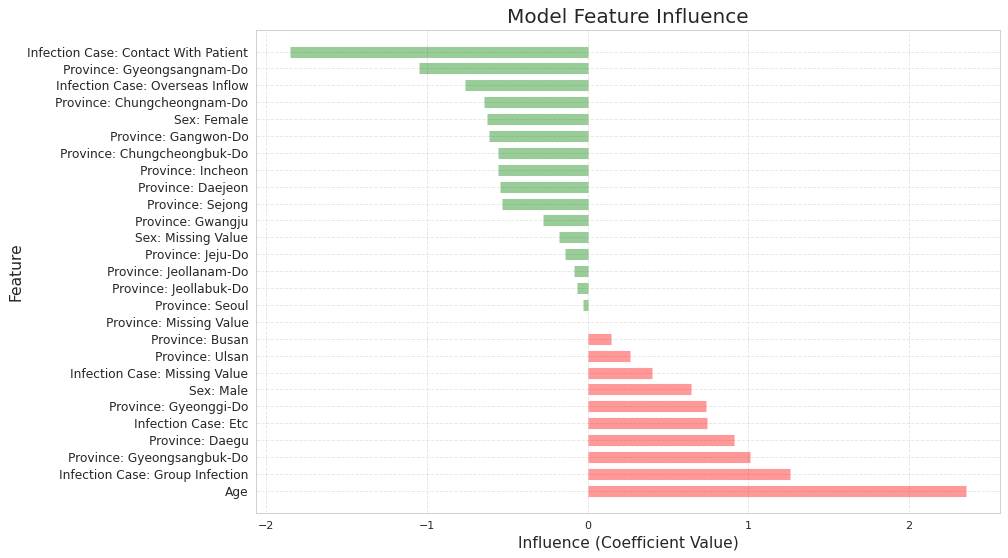

In [74]:
# Draw plot
f = plt.figure(figsize=(12,8), dpi= 80)
plt.hlines(y=model_coefs_df.index, xmin=0, xmax=model_coefs_df.coef, 
           color=model_coefs_df.color, alpha=0.4, linewidth=10)

# Decorations
plt.gca().set_xlabel(xlabel='Influence (Coefficient Value)', fontsize=14)
plt.gca().set_ylabel(ylabel='Feature', fontsize=14)
plt.yticks(model_coefs_df.index, model_coefs_df.pretty_feature_name, fontsize=11)
plt.title('Model Feature Influence', fontdict={'size':18})
plt.grid(linestyle='--', alpha=0.5)
plt.show()

# Save plot image
f.savefig("../../assets/q2-patient-status-influencers.png", bbox_inches='tight', dpi=600);

In the chart above, we see how the patient characteristics (features) affect the model prediction. Each bar indicates the influence of a single feature. Its length denotes the magnitude of such influence and its side / color indicates whether it influences towards the released (left / green) or deceased (right / red) status.

As we can see, the main influencing factor is Age Range: the higher the age the higher the odds of death (as expected). The analysis of the categorical features can give us interesting insights. In regard to the infection case feature, the contact with other patients and overseas inflow (someone who got infected outside the country) seem to act against death, as group infection cases tend to provide a higher death risk, which suggests the importance of avoiding crowds. This needs further investigation to verify if the patients in part of each infection case cluster had other characteristics which would contribute to higher/lower death odds.

Also, building on the previous analysis, residing in provinces with higher infection rates (Daegu and Gyeongsangbuk-do) and being male points towards a higher risk, in opposition to residing in provinces with lower disease spread (such as Chungcheongnam-do) and being female, which decreases death risk.

***

### III - What are the riskiest locations for COVID-19 infection in Seoul (where infected people have visited the most)?

In order to perform this analysis, I used the patient route data, which consists of GPS data points of places visited by patients in the days before their COVID-19 diagnosis confirmation. The points were matched to their respective neighborhood (also known as dongs) and then aggregated.

#### Reading Data - Patient Route

In [75]:
patient_route = pd.read_csv('../../data/PatientRoute.csv')

#### Taking a look at the data

In [76]:
patient_route.head(20)

,patient_id,global_num,date,province,city,type,latitude,longitude
0,1000000001,2.0,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.615246,126.715632
1,1000000001,2.0,2020-01-24,Seoul,Jung-gu,hospital,37.567241,127.005659
2,1000000002,5.0,2020-01-25,Seoul,Seongbuk-gu,etc,37.592560,127.017048
3,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,store,37.591810,127.016822
4,1000000002,5.0,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.563992,127.029534
5,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,public_transportation,37.590330,127.015221
6,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,store,37.589590,127.009766
7,1000000002,5.0,2020-01-27,Seoul,Seongbuk-gu,restaurant,37.592057,127.018898
8,1000000002,5.0,2020-01-27,Seoul,Dongdaemun-gu,store,37.566262,127.065815
9,1000000002,5.0,2020-01-28,Seoul,Seongbuk-gu,etc,37.591669,127.018420


In [77]:
patient_route.describe()

,patient_id,global_num,latitude,longitude
count,5.963000e+03,3154.000000,5963.000000,5963.000000
mean,2.492088e+09,6303.317058,36.744703,127.627235
std,1.951605e+09,3590.101111,0.935144,0.908103
min,1.000000e+09,2.000000,33.454642,126.301005
25%,1.000000e+09,2818.000000,35.871435,126.940584
50%,1.100000e+09,7688.000000,37.342219,127.106542
75%,4.100000e+09,9080.500000,37.515846,128.597562
max,6.100000e+09,10659.000000,38.193169,129.475746


In [78]:
patient_route.describe(include=['object'])

,date,province,city,type
count,5963,5963,5963,5963
unique,89,16,149,23
top,2020-02-24,Seoul,Cheonan-si,hospital
freq,322,2256,465,1790


In [79]:
places_per_patient = patient_route.groupby('patient_id').type.count()

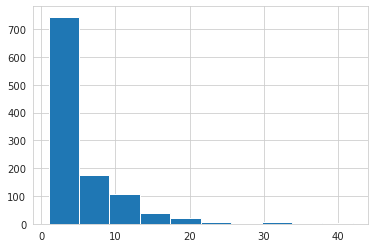

In [80]:
places_per_patient.hist();

#### Most common places visited by infected people

In [81]:
def plot_categorical_col_dist(df, col_name, plot_title, first_n=-1):
    '''
    INPUT
    df - pandas dataframe, patient route data
    col_name - column name string
    plot_title - plot title string
    first_n - int, default -1 (all), N top categories to display

    OUTPUT
    A categorical column distribution bar plot
    
    This function plots the distribution of a categorical column in a dataframe using a bar plot
    '''
    category_counts = df[col_name].value_counts()
    if (first_n != -1):
        category_counts = category_counts[:first_n]
    (category_counts/df.shape[0]).plot(kind="bar");
    plt.title(plot_title);

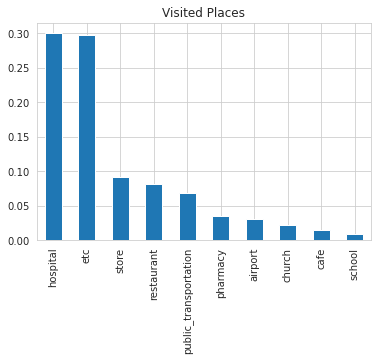

In [82]:
plot_categorical_col_dist(patient_route, 'type', 'Visited Places', 10)

#### Visualize patient route stops on map

##### Analysis will be performed only for Seoul province

In [83]:
seoul_p_route = patient_route[patient_route['province'] == 'Seoul']
print(seoul_p_route.shape)
seoul_p_route.head()

(2256, 8)


,patient_id,global_num,date,province,city,type,latitude,longitude
1,1000000001,2.0,2020-01-24,Seoul,Jung-gu,hospital,37.567241,127.005659
2,1000000002,5.0,2020-01-25,Seoul,Seongbuk-gu,etc,37.592560,127.017048
3,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,store,37.591810,127.016822
4,1000000002,5.0,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.563992,127.029534
5,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,public_transportation,37.590330,127.015221


##### Adding fortnight info to date

In [84]:
def get_fortnight(date):
    '''
    INPUT:
    date - the date string

    OUTPUT:
    the date month-based fortnight string (in the form: [Month]-[Fortnight-Number])
    
    This function returns the month-based fortnight of a given date for the period of the patient route data.
    '''
    if date <= '2020-01-31':
        return 'Jan-2'
    elif date <= '2020-02-15':
        return 'Feb-1'
    elif date <= '2020-02-28':
        return 'Feb-2'
    elif date <= '2020-03-15':
        return 'Mar-1'
    elif date <= '2020-03-31':
        return 'Mar-2'
    elif date <= '2020-04-15':
        return 'Apr-1'
    elif date <= '2020-05-01':
        return 'Apr-2'

seoul_p_route['fortnight'] = seoul_p_route.date.transform(lambda x: get_fortnight(x))

/local/tarciso/anaconda3/envs/udacity-ds-p1/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [85]:
seoul_p_route.head()

,patient_id,global_num,date,province,city,type,latitude,longitude,fortnight
1,1000000001,2.0,2020-01-24,Seoul,Jung-gu,hospital,37.567241,127.005659,Jan-2
2,1000000002,5.0,2020-01-25,Seoul,Seongbuk-gu,etc,37.592560,127.017048,Jan-2
3,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,store,37.591810,127.016822,Jan-2
4,1000000002,5.0,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.563992,127.029534,Jan-2
5,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,public_transportation,37.590330,127.015221,Jan-2


##### Encode geographic info

In [86]:
seoul_p_route['risk_location'] = list(zip(seoul_p_route.longitude, seoul_p_route.latitude))
seoul_p_route['risk_location'] = seoul_p_route['risk_location'].apply(geom.Point)
seoul_p_route_gdf = geopandas.GeoDataFrame(seoul_p_route, geometry='risk_location')

/local/tarciso/anaconda3/envs/udacity-ds-p1/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/local/tarciso/anaconda3/envs/udacity-ds-p1/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##### Read Seoul Shape

In [87]:
seoul_shape = geopandas.read_file('../../data/shapefiles/seoul/seoul-maps/juso/2015/shp/seoul_neighborhoods.shp')

In [88]:
seoul_shape

,EMD_CD,EMD_KOR_NM,EMD_ENG_NM,ESRI_PK,SHAPE_AREA,SHAPE_LEN,geometry
0,11590108,대방동,Daebang-dong,18,0.000157,0.063998,"POLYGON ((126.93240 37.51558, 126.93243 37.515..."
1,11110118,내수동,Naesu-dong,59,0.000007,0.011823,"POLYGON ((126.97318 37.57399, 126.97328 37.573..."
2,11590105,흑석동,Heukseok-dong,15,0.000171,0.057420,"POLYGON ((126.96639 37.51014, 126.96687 37.509..."
3,11320107,창동,Chang-dong,1,0.000436,0.100323,"POLYGON ((127.05147 37.66043, 127.05150 37.659..."
4,11230107,청량리동,Cheongnyangni-dong,8,0.000122,0.064774,"POLYGON ((127.04305 37.59696, 127.04361 37.596..."
...,...,...,...,...,...,...,...
462,11170133,서빙고동,Seobinggo-dong,461,0.000081,0.038065,"POLYGON ((126.99185 37.52515, 126.99187 37.525..."
463,11170134,주성동,Juseong-dong,462,0.000018,0.021908,"POLYGON ((126.99820 37.52448, 126.99838 37.524..."
464,11170122,문배동,Munbae-dong,442,0.000012,0.018005,"POLYGON ((126.97095 37.53772, 126.97095 37.537..."
465,11170103,용산동4가,Yongsan-dong 4(sa)-ga,447,0.000081,0.036409,"POLYGON ((126.98810 37.53433, 126.98816 37.534..."


##### Set the CRS of the points to the CRS of Seoul's shapefile

In [89]:
seoul_p_route_gdf.crs = seoul_shape.crs

##### Trying some visualizations

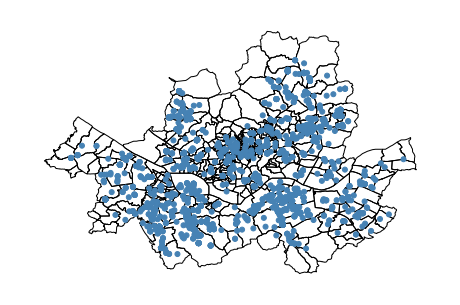

In [90]:
# Plot Seoul neighborhoods map with patient route location points
ax = geoplot.pointplot(seoul_p_route_gdf)
geoplot.polyplot(seoul_shape, ax=ax);

/local/tarciso/anaconda3/envs/udacity-ds-p1/lib/python3.6/site-packages/geoplot/geoplot.py:1743: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  url=getattr(ctx.sources, provider), ll=True


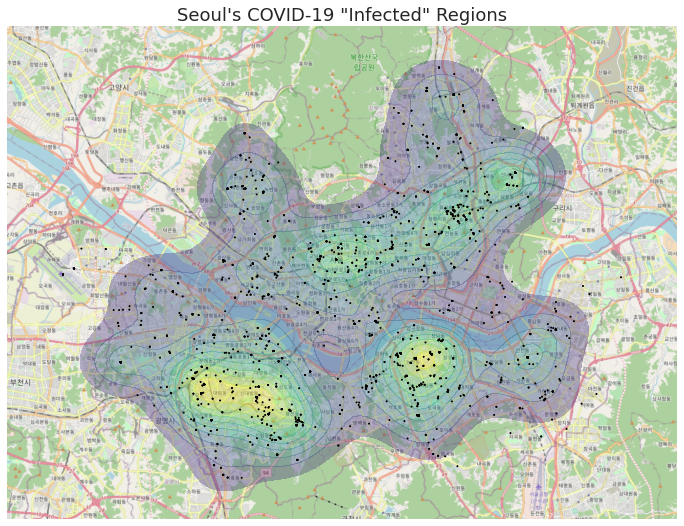

In [91]:
# Plot KDE Plot to visualize the distribution of infected patient route locations on map
ax = geoplot.kdeplot(
    seoul_p_route_gdf, cmap='viridis', projection=geoplot.crs.WebMercator(), figsize=(12, 12), 
    alpha = 0.35, shade=True
)
geoplot.pointplot(seoul_p_route_gdf, s=1, color='black', ax=ax)
geoplot.webmap(seoul_p_route_gdf, ax=ax)
plt.title('Seoul\'s COVID-19 "Infected" Regions', fontsize=18);

Here we see the overall distribution of the infected patients route locations in the map of Seoul. The locations are more concentrated in the central region of the province, and towards the south of Han River.

##### Plot infected patients route locations distribution over time (fortnights since the beginning of the pandemic in S. Korea)

In [92]:
def plot_kde_infected_areas(infected_places_df, axis, province=None, start_date=None, end_date=None, fortnight=None):
    '''
    INPUT:
    infected_places_df - pandas dataframe, a dataframe holding the infected places data
    axis - matplotlib axis, the axis to be used by the plot
    province - string, default None, the province name
    start_date - string, default None, the start date which will be used to filter the data for plotting
    end_date - string, default None, the end date which will be used to filter the data for plotting
    fortnight - string, default None, the fortnight which will be used to filter the data for plotting

    OUTPUT:
    A geomap plot comprised of Seoul's webmap, a point plot of the infection places locations, and
    a KDE plot with the infection locations distribution heatmap
    
    This function plots the infection places in Seoul using a composition of a webmap, a point plot and a KDE plot
    '''
    
    # Applying input filters to data
    filtered_inf_places_df = infected_places_df
    if (province != None):
        #print("Filtering by province: " + province)
        filtered_inf_places_df = filtered_inf_places_df[filtered_inf_places_df['province'] == province]
    if (start_date != None):
        #print("Filtering by start date: " + start_date)
        filtered_inf_places_df = filtered_inf_places_df[filtered_inf_places_df['date'] >= start_date]
    if (end_date != None):
        #print("Filtering by end date: " + end_date)
        filtered_inf_places_df = filtered_inf_places_df[filtered_inf_places_df['date'] <= end_date]
    if (fortnight != None):
        #print("Filtering by fortnight: " + fortnight)
        filtered_inf_places_df = filtered_inf_places_df[filtered_inf_places_df['fortnight'] == fortnight]
        
    # Plotting KDE Plot with distribution of locations on the map
    geoplot.kdeplot(filtered_inf_places_df, cmap='viridis', projection=geoplot.crs.WebMercator(), alpha = 0.35, shade=True, ax=axis)
    
    # Plotting location points on the map
    geoplot.pointplot(filtered_inf_places_df, s=2, color='black', ax=axis)
    
    # Plotting webmap with Seoul neighborhoods shape
    geoplot.webmap(seoul_shape, ax=axis)
    
    # Setting title label
    province_title = ((province + ' ') if province != None else '')
    fortnight_title = ((' for ' + fortnight) if fortnight != None else '')
    axis.set_title(province_title + 'COVID-19 "Infected" Regions' + fortnight_title)

/local/tarciso/anaconda3/envs/udacity-ds-p1/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)
/local/tarciso/anaconda3/envs/udacity-ds-p1/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  if sys.path[0] == '':


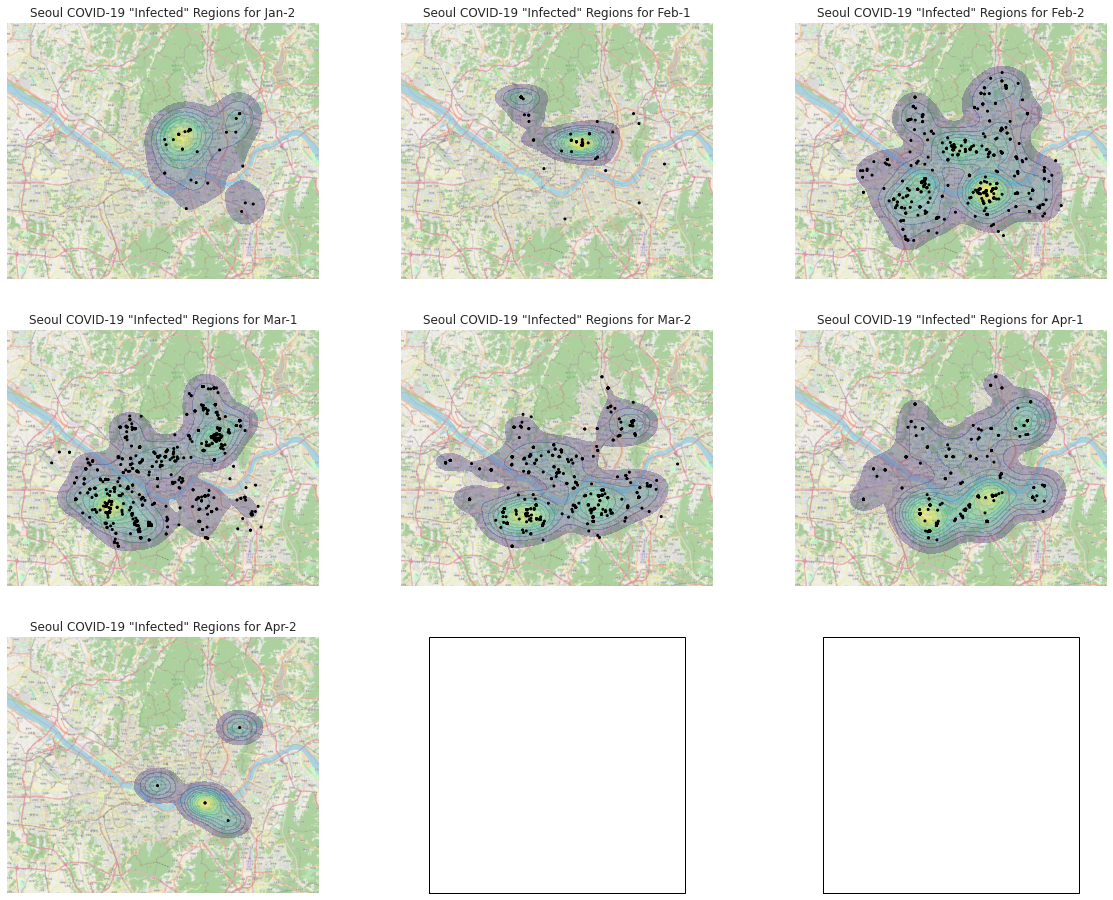

In [93]:
# Plotting infected patients route locations distribution over time (fortnights since the beginning of the pandemic in S. Korea)
f, axes = plt.subplots(figsize=(20, 16), ncols=3, nrows=3,subplot_kw={'projection': geoplot.crs.WebMercator()})
plot_kde_infected_areas(seoul_p_route_gdf, axis=axes[0][0], province='Seoul', fortnight='Jan-2');
plot_kde_infected_areas(seoul_p_route_gdf, axis=axes[0][1], province='Seoul', fortnight='Feb-1');
plot_kde_infected_areas(seoul_p_route_gdf, axis=axes[0][2], province='Seoul', fortnight='Feb-2');
plot_kde_infected_areas(seoul_p_route_gdf, axis=axes[1][0], province='Seoul', fortnight='Mar-1');
plot_kde_infected_areas(seoul_p_route_gdf, axis=axes[1][1], province='Seoul', fortnight='Mar-2');
plot_kde_infected_areas(seoul_p_route_gdf, axis=axes[1][2], province='Seoul', fortnight='Apr-1');
plot_kde_infected_areas(seoul_p_route_gdf, axis=axes[2][0], province='Seoul', fortnight='Apr-2');

plt.setp(axes, yticks=[])
plt.tight_layout();

As we can see in the above maps, the risky locations were mostly in the central region, north of Han River in late January, as of the first cases. Later on it spread to the south of the river which overtook the majority of the route locations. By the end of April, we see the diminishing of the points / locations in the map, which is probably due to the reduction in the number of new cases.

##### Matching route places with Seoul shape neighborhoods

In [94]:
seoul_p_route_gdf.head()

,patient_id,global_num,date,province,city,type,latitude,longitude,fortnight,risk_location
1,1000000001,2.0,2020-01-24,Seoul,Jung-gu,hospital,37.567241,127.005659,Jan-2,POINT (127.00566 37.56724)
2,1000000002,5.0,2020-01-25,Seoul,Seongbuk-gu,etc,37.592560,127.017048,Jan-2,POINT (127.01705 37.59256)
3,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,store,37.591810,127.016822,Jan-2,POINT (127.01682 37.59181)
4,1000000002,5.0,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.563992,127.029534,Jan-2,POINT (127.02953 37.56399)
5,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,public_transportation,37.590330,127.015221,Jan-2,POINT (127.01522 37.59033)


In [95]:
seoul_shape.head()

,EMD_CD,EMD_KOR_NM,EMD_ENG_NM,ESRI_PK,SHAPE_AREA,SHAPE_LEN,geometry
0,11590108,대방동,Daebang-dong,18,0.000157,0.063998,"POLYGON ((126.93240 37.51558, 126.93243 37.515..."
1,11110118,내수동,Naesu-dong,59,0.000007,0.011823,"POLYGON ((126.97318 37.57399, 126.97328 37.573..."
2,11590105,흑석동,Heukseok-dong,15,0.000171,0.057420,"POLYGON ((126.96639 37.51014, 126.96687 37.509..."
3,11320107,창동,Chang-dong,1,0.000436,0.100323,"POLYGON ((127.05147 37.66043, 127.05150 37.659..."
4,11230107,청량리동,Cheongnyangni-dong,8,0.000122,0.064774,"POLYGON ((127.04305 37.59696, 127.04361 37.596..."


In [96]:
# Spatially joining infected patients route locations with seoul neighborhood shapes
seoul_risk_places_nbh_gdf = geopandas.sjoin(seoul_shape, seoul_p_route_gdf, op='intersects', how='left')

In [97]:
seoul_risk_places_nbh_gdf

,EMD_CD,EMD_KOR_NM,EMD_ENG_NM,ESRI_PK,SHAPE_AREA,SHAPE_LEN,geometry,index_right,patient_id,global_num,date,province,city,type,latitude,longitude,fortnight
0,11590108,대방동,Daebang-dong,18,0.000157,0.063998,"POLYGON ((126.93240 37.51558, 126.93243 37.515...",2192.0,1.000001e+09,10313.0,2020-04-06,Seoul,Dongjak-gu,hospital,37.498815,126.923930,Apr-1
0,11590108,대방동,Daebang-dong,18,0.000157,0.063998,"POLYGON ((126.93240 37.51558, 126.93243 37.515...",1427.0,1.000000e+09,8446.0,2020-03-15,Seoul,Dongjak-gu,school,37.501597,126.922227,Mar-1
0,11590108,대방동,Daebang-dong,18,0.000157,0.063998,"POLYGON ((126.93240 37.51558, 126.93243 37.515...",1441.0,1.000000e+09,8456.0,2020-03-15,Seoul,Dongjak-gu,school,37.501597,126.922227,Mar-1
0,11590108,대방동,Daebang-dong,18,0.000157,0.063998,"POLYGON ((126.93240 37.51558, 126.93243 37.515...",758.0,1.000000e+09,7437.0,2020-02-29,Seoul,Dongjak-gu,etc,37.508096,126.926254,Mar-1
0,11590108,대방동,Daebang-dong,18,0.000157,0.063998,"POLYGON ((126.93240 37.51558, 126.93243 37.515...",4076.0,3.013000e+09,NaN,2020-02-22,Seoul,Dongjak-gu,public_transportation,37.512554,126.926371,Feb-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,11170112,원효로1가,Wonhyoro 1(iI)-ga,449,0.000021,0.020099,"POLYGON ((126.97052 37.54154, 126.97058 37.541...",2092.0,1.000001e+09,10186.0,2020-04-03,Seoul,Yongsan-gu,hospital,37.538427,126.965444,Apr-1
466,11170112,원효로1가,Wonhyoro 1(iI)-ga,449,0.000021,0.020099,"POLYGON ((126.97052 37.54154, 126.97058 37.541...",1236.0,1.000000e+09,7980.0,2020-03-09,Seoul,Yongsan-gu,etc,37.538427,126.965444,Mar-1
466,11170112,원효로1가,Wonhyoro 1(iI)-ga,449,0.000021,0.020099,"POLYGON ((126.97052 37.54154, 126.97058 37.541...",1458.0,1.000000e+09,8617.0,2020-03-19,Seoul,Yongsan-gu,hospital,37.538427,126.965444,Mar-2
466,11170112,원효로1가,Wonhyoro 1(iI)-ga,449,0.000021,0.020099,"POLYGON ((126.97052 37.54154, 126.97058 37.541...",1457.0,1.000000e+09,8617.0,2020-03-18,Seoul,Yongsan-gu,hospital,37.538427,126.965444,Mar-2


In [98]:
# Checking dataframes sizes
print(seoul_p_route_gdf.shape)
print(seoul_risk_places_nbh_gdf.shape)

(2256, 10)
(2492, 17)


In [99]:
# Creating dataframe with number of risk places per neighborhood
seoul_risk_places_per_nbh = seoul_risk_places_nbh_gdf.groupby(['EMD_CD', 'EMD_KOR_NM','EMD_ENG_NM']) \
                                .agg({'index_right':lambda x: x.count()}) \
                                .reset_index() \
                                .rename(index=str, columns= {'index_right':'num_risk_places'})
seoul_risk_places_per_nbh = seoul_risk_places_per_nbh.merge(seoul_shape, on=['EMD_CD', 'EMD_KOR_NM','EMD_ENG_NM'])
seoul_risk_places_per_nbh_gdf = geopandas.GeoDataFrame(seoul_risk_places_per_nbh, geometry='geometry')
seoul_risk_places_per_nbh_gdf

,EMD_CD,EMD_KOR_NM,EMD_ENG_NM,num_risk_places,ESRI_PK,SHAPE_AREA,SHAPE_LEN,geometry
0,11110101,청운동,Cheongun-dong,0.0,42,0.000081,0.042186,"POLYGON ((126.97151 37.59368, 126.97157 37.593..."
1,11110102,신교동,Singyo-dong,0.0,43,0.000010,0.014906,"POLYGON ((126.96917 37.58584, 126.96914 37.585..."
2,11110103,궁정동,Gungjeong-dong,0.0,44,0.000007,0.013882,"POLYGON ((126.97386 37.58658, 126.97400 37.586..."
3,11110104,효자동,Hyoja-dong,0.0,52,0.000006,0.010860,"POLYGON ((126.97341 37.58355, 126.97350 37.583..."
4,11110105,창성동,Changseong-dong,0.0,53,0.000006,0.010103,"POLYGON ((126.97375 37.58110, 126.97377 37.580..."
...,...,...,...,...,...,...,...,...
462,11740106,둔촌동,Dunchon-dong,0.0,246,0.000251,0.080648,"POLYGON ((127.15671 37.53757, 127.15656 37.537..."
463,11740107,암사동,Amsa-dong,0.0,225,0.000479,0.100510,"POLYGON ((127.14432 37.55497, 127.14422 37.554..."
464,11740108,성내동,Seongnae-dong,24.0,205,0.000199,0.060985,"POLYGON ((127.12364 37.53895, 127.12365 37.538..."
465,11740109,천호동,Cheonho-dong,5.0,229,0.000312,0.093699,"POLYGON ((127.14272 37.55068, 127.14275 37.550..."


In [100]:
seoul_risk_places_per_nbh_gdf.dtypes

EMD_CD               object
EMD_KOR_NM           object
EMD_ENG_NM           object
num_risk_places     float64
ESRI_PK               int64
SHAPE_AREA          float64
SHAPE_LEN           float64
geometry           geometry
dtype: object

In [101]:
seoul_shape.shape

(467, 7)

##### Top Risky Neighborhoods

In [102]:
top_risk_nbhs = seoul_risk_places_per_nbh_gdf[['EMD_CD','geometry','EMD_KOR_NM','EMD_ENG_NM','num_risk_places']].sort_values('num_risk_places', ascending=False)
# Setting Top Risk neighborhoods CRS to be the same as Seoul Shape CRS
top_risk_nbhs.crs = seoul_shape.crs
top_risk_nbhs

,EMD_CD,geometry,EMD_KOR_NM,EMD_ENG_NM,num_risk_places
363,11530102,"POLYGON ((126.89283 37.50347, 126.89276 37.503...",구로동,Guro-dong,147.0
236,11260106,"POLYGON ((127.11132 37.62070, 127.11216 37.620...",신내동,Sinnae-dong,102.0
434,11680105,"POLYGON ((127.06758 37.52231, 127.06761 37.521...",삼성동,Samseong-dong,81.0
418,11620101,"POLYGON ((126.92803 37.49503, 126.92823 37.494...",봉천동,Bongcheon-dong,80.0
417,11590109,"POLYGON ((126.92916 37.49844, 126.92924 37.498...",신대방동,Sindaebang-dong,80.0
...,...,...,...,...,...
169,11170109,"POLYGON ((126.96723 37.55075, 126.96735 37.550...",청파동1가,Cheongpa-dong 1(il)-ga,0.0
168,11170108,"POLYGON ((126.96919 37.55466, 126.96919 37.554...",서계동,Seogye-dong,0.0
163,11170103,"POLYGON ((126.98810 37.53433, 126.98816 37.534...",용산동4가,Yongsan-dong 4(sa)-ga,0.0
160,11140174,"POLYGON ((126.96578 37.55417, 126.96577 37.554...",만리동2가,Malli-dong 2(i)-ga,0.0


In [103]:
top_risk_nbhs.describe()

,num_risk_places
count,467.000000
mean,4.830835
std,13.147368
min,0.000000
25%,0.000000
50%,0.000000
75%,4.000000
max,147.000000


##### Plotting Seoul's Neighborhoods and highlight Top 10 Risky NBHDs

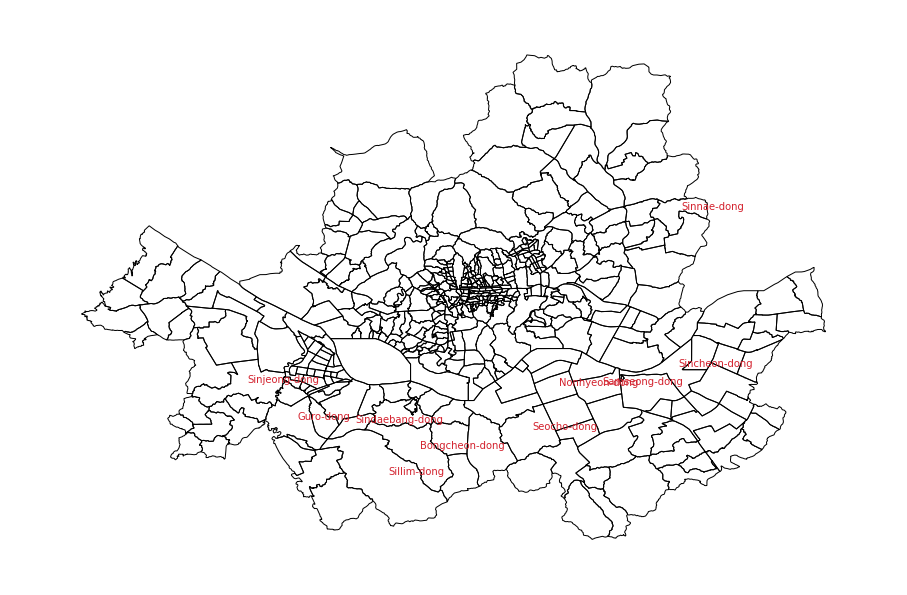

In [104]:
ax = geoplot.polyplot(seoul_shape, figsize=(16,12));

top_10_nbhs_data = top_risk_nbhs.head(10)

for x, y, label in zip(top_10_nbhs_data.geometry.centroid.x, top_10_nbhs_data.geometry.centroid.y, top_10_nbhs_data.EMD_ENG_NM):
    ax.annotate(label, xy=(x, y), color='#D3212D', xytext=(3, 3), textcoords="offset points", clip_on=True)

### Answer to Question III

#### Creating a Choropleth to show the most risky neighborhoods

##### Defining Choropleth data breaks

In [105]:
scheme = mapclassify.UserDefined(seoul_risk_places_per_nbh['num_risk_places'], bins=[5, 25, 50, 100])

In [106]:
scheme

UserDefined             

    Interval       Count
------------------------
[  0.00,   5.00] |   376
(  5.00,  25.00] |    69
( 25.00,  50.00] |    15
( 50.00, 100.00] |     5
(100.00, 147.00] |     2

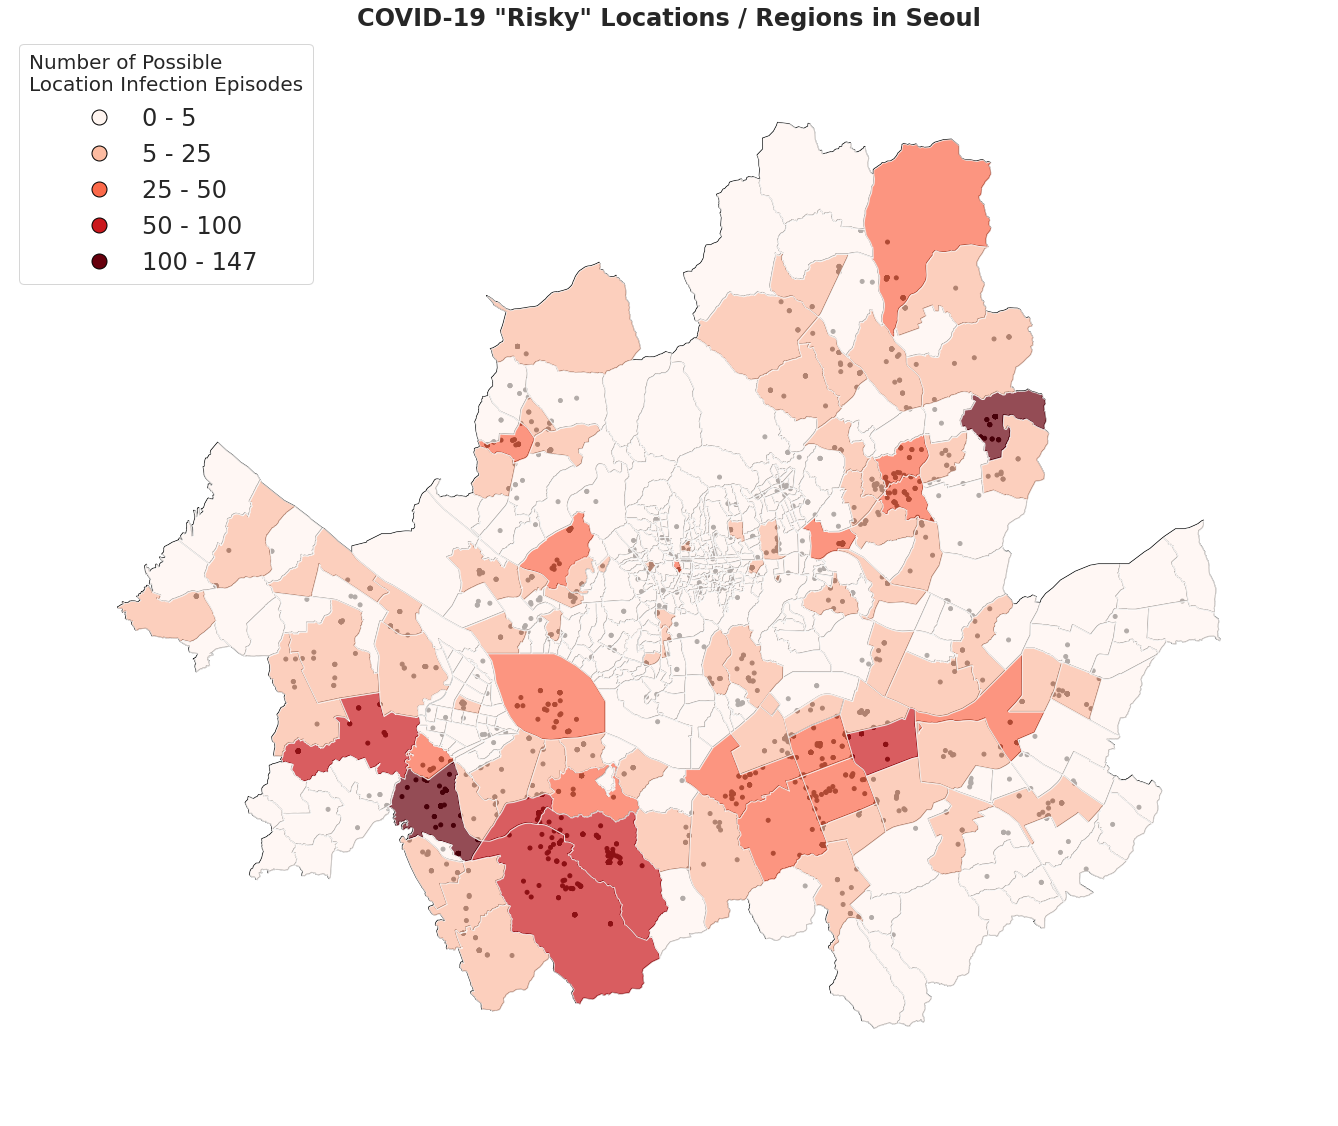

In [107]:
# Plotting Choropleth with the neighborhoods colored by their infection risk
f, axis = plt.subplots(figsize=(30, 20),subplot_kw={'projection': geoplot.crs.WebMercator()})

geoplot.choropleth(
    seoul_risk_places_per_nbh_gdf, 
    hue=seoul_risk_places_per_nbh_gdf.num_risk_places, 
    scheme=scheme,
    cmap='Reds', 
    legend=True, 
    projection=geoplot.crs.WebMercator(), 
    alpha=0.7,ax = axis,
    legend_kwargs={'title': 'Number of Possible\nLocation Infection Episodes',
                   'fontsize': 24, 
                   'markersize':15,
                   'markeredgecolor':'black',
                   'title_fontsize': 20,
                   'loc':'upper left'}    
)

# Plotting infected patients route locations as a point plot
geoplot.pointplot(seoul_p_route_gdf, s=4, color='black', ax=axis)

# Plotting Seoul's neighborhoods shapes as a polygon plot
geoplot.polyplot(seoul_shape, ax=axis);

# Setting final plot title
axis.set_title('COVID-19 "Risky" Locations / Regions in Seoul', fontsize=24, fontweight="bold");

# Saving plot image to file
f.savefig("../../assets/q3-seoul-risky-locs.png", bbox_inches='tight', dpi=600)

In the map above, we see Seoul’s neighborhoods. Each point represents a place visited by a COVID-19 infected patient, and thus a possible location infection episode. The color of each neighborhood represents the risk that is given by the accumulated number of “possible location infection episodes”.

Here we see that the vast majority of the neighborhoods have 5 or less possible location infection episodes, and only two have more than 100. Moreover, riskier neighborhoods are mostly located in the south of the province.

##### Listing Top-10 Risky Neighborhoods

In [108]:
top10_risk_nbhs = top_risk_nbhs.assign(RANK = range(1, len(top_risk_nbhs) + 1)) \
                     .head(10)[['RANK','EMD_KOR_NM','EMD_ENG_NM','num_risk_places']] \
                     .rename(index=str, columns={'EMD_KOR_NM':'NBHD_KOREAN','EMD_ENG_NM':'NBHD_ENGLISH',
                                                 'num_risk_places':'LOC_INF_EPS'}) \
                     .reset_index(drop=True)
top10_risk_nbhs

,RANK,NBHD_KOREAN,NBHD_ENGLISH,LOC_INF_EPS
0,1,구로동,Guro-dong,147.0
1,2,신내동,Sinnae-dong,102.0
2,3,삼성동,Samseong-dong,81.0
3,4,봉천동,Bongcheon-dong,80.0
4,5,신대방동,Sindaebang-dong,80.0
5,6,신정동,Sinjeong-dong,68.0
6,7,신림동,Sillim-dong,66.0
7,8,신천동,Sincheon-dong,49.0
8,9,서초동,Seocho-dong,48.0
9,10,논현동,Nonhyeon-dong,45.0


By looking at the table above, we see that only 7 neighborhoods had 50 or more possible place-infection episodes. Guro-dong and Sinae-dong were the top-2 risky neighborhoods (with over 100 episodes). Guro-dong’s numbers might be related to Seoul’s biggest infection cluster — a group infection occurred in a call center which operates in a 19-story building in an adjacent neighborhood.

An interesting next-step would be to run this analysis for subsequent time periods and observe the evolution of the scenario. I've started this analysis but did not present here in order to keep the article more concise.

***

## Conclusions

In this notebook, we have explored South Korea’s COVID-19 data as a practical Data Science task with the means to find insights and acquire knowledge about the ongoing pandemic, its causes, aspects and impacts.

1. First, we analyzed how the infection spread through the country provinces over time and found out Daegu was the epicenter of the infection and the majority of the most-infected provinces were able to control the dissemination after the 20th day since the first infection.


2. Next, we explored the effect of some patients’ characteristics in predicting their status, finding that being of older age and male seem to count towards deceasement, and that the type of infection might have an influence in the patient status, which needs to be further investigated.


3. Last, we looked at the distribution of possible location infection episodes within Seoul, concluding most of the neighborhoods have very few risk points, the majority of riskier dongs are located in the south region, and Guro-dong and Sinnae-dong concentrate most of the risk locations.

Notice: the conclusions drawn here are part of a non-scientific/formal study and thus, further analysis must be made in order to make decisions based on this data.
